# Deliverable D4.12
## Investage issues with key estimation and apple loops dataset

In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
from collections import defaultdict
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['apple_loops_db']
datasets = load_datasets(dirnames=dataset_dirnames, clean=True, exclude_files=['analysis_freesound_extractor_04.json'])  # Load and clean datasets
methods_to_compare = ['ACExtractorV2', 'ACExtractorV3', 'EdmkeyShaath']
accuracy_functions = [mireval_key_same, mireval_key_fifth, mireval_key_relative, mireval_key_parallel, mireval_key_weighted_score]
accuracy_functions_names = ['Same', 'Fifth', 'Relative', 'Parallel', 'Mirex']

DISPLAY_NAMES = {
'EdmkeyShaath': 'EDMKey1',
'EdmkeyKrumhansl': 'EDMKey2',
'EdmkeyTemperley': 'EDMKey3',
'ACExtractorV1': 'ACExtractorV1',
'ACExtractorV2': 'ACExtractorV2',
'QMULKeyDetector': 'QMULKey',
}

In [2]:
new_datasets = []
for count, dataset in enumerate(datasets):
    try:
        with open('dataset_curation_{0}.txt'.format(dataset.short_name), 'r') as fid:
            sids_response = {}
            for line in fid.readlines():
                sid, response_raw = line.split(' - ')
                if 'YES' in response_raw:
                    sids_response[sid] = True
                else:
                    sids_response[sid] = False                
        allowed_dataset_ids = [key for key, value in sids_response.items() if value == True]
        filtered_dataset = dataset.filter_data(condition=lambda x, y, z: x in allowed_dataset_ids)
        filtered_dataset.short_name = dataset.short_name + '-rel'
        filtered_dataset.name = dataset.name + ' - Reliable'
        new_datasets.append(dataset)
        new_datasets.append(filtered_dataset)     
    except FileNotFoundError:
        new_datasets.append(dataset)
        
datasets= new_datasets



General key estimation results (APPL)
**************************************


Method          Same    Fifth   Relative   Parallel   Mirex   % analysis failed   
----------------------------------------------------------------------------------
EDMKey1         38.53   8.28    7.00       13.23      47.42   1.20                
ACExtractorV2   24.94   3.54    8.57       5.36       30.35   0.87                


General key estimation results (APPL-rel)
******************************************


Method          Same    Fifth   Relative   Parallel   Mirex   % analysis failed   
----------------------------------------------------------------------------------
EDMKey1         57.58   8.08    13.13      11.11      67.78   0.00                
ACExtractorV2   32.32   5.05    13.13      1.01       38.99   0.00                


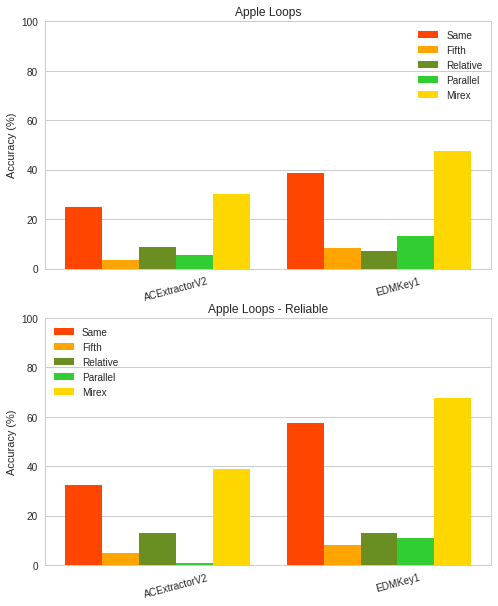

In [3]:
all_datasets_method_results = defaultdict(list)
all_datasets_method_results_stats = defaultdict(list)
fig1, axs = plt.subplots(len(datasets), 1, figsize=(8, 5*len(datasets)))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral key estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names + ['% analysis failed']
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = defaultdict(list)
            all_datasets_method_results_stats[method] = defaultdict(list)
        try:
            table_row = [DISPLAY_NAMES.get(method, method)]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                acc_method_avg = 100 * basic_statistics(method_results)['avg']
                table_row.append(acc_method_avg)
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
                all_datasets_method_results_stats[method][accuracy_func.__name__].append(acc_method_avg)
                
            n_analysis_failed = len([item for item in dataset.data.values() if not item['analysis'].get(method, False)])
            table_row.append(100 * n_analysis_failed / len(dataset.data))

            table_rows.append(table_row)
        except IndexError as e:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    #ax = axs[count//2,count%2]
    ax = axs[count]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method)  for method in methods_to_compare], rotation=15)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [4]:
print(title("General key estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names
table_rows = list()
for method, results in all_datasets_method_results_stats.items():
    table_row = [DISPLAY_NAMES.get(method, method) ]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(basic_statistics(data)['avg'])
    table_rows.append(table_row)
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)



General key estimation results (ALL DATASETS)
---------------------------------------------

Method          Same    Fifth   Relative   Parallel   Mirex   
--------------------------------------------------------------
EDMKey1         48.06   8.18    10.07      12.17      57.60   
ACExtractorV2   28.63   4.29    10.85      3.18       34.67   


In [8]:
from ac_utils.analysis_algorithms import algorithm_ac_extractor3
import pymtg

ds = datasets[1]

wp = pymtg.processing.WorkParallelizer()

def analyze(sound_id, sound):
    sound_path = os.path.join(settings.DATA_PATH, ds.dirname, sound['wav_sound_path'])
    sound['file_path'] = sound_path
    if 'ACExtractorV3' not in sound:
        results_acext = algorithm_ac_extractor3(sound)    
        sound['analysis']['ACExtractorV3'] = results_acext['ACExtractorV3']
    return (sound_id, sound)
    
for sound_id, sound in [*ds.data.items()]:
    wp.add_task(analyze, sound_id, sound)
                
wp.run(num_workers=4)

# Show errors after computing all tasks (if any)
if wp.num_tasks_failed > 0:
    wp.show_errors()
    
# Store results in analysis dict
for t in wp.tasks_succeeded():
    sound_id, updated_sound = t.result()
    ds.data[sound_id] = updated_sound

Submitting 99 tasks to 4 workers
[99/99, 0 running] 0:00:00 remaining15 remainingggg
All tasks compelted! [99 succeeded, 0 failed]


In [15]:
# Compute results

dataset = datasets[1]
methods_to_compare = ['ACExtractorV3', 'ACExtractorV2', 'EdmkeyShaath']

print(title("\nGeneral key estimation results (%s)" % dataset.short_name, c='*'))
table_header = ['Method'] + accuracy_functions_names + ['% analysis failed']
table_rows = list()

for method in methods_to_compare:
    try:
        table_row = [DISPLAY_NAMES.get(method, method)]
        for accuracy_func in accuracy_functions:
            method_results = accuracy_func(dataset.data, method)
            acc_method_avg = 100 * basic_statistics(method_results)['avg']
            table_row.append(acc_method_avg)
          
        n_analysis_failed = len([item for item in dataset.data.values() if not item['analysis'].get(method, False)])
        table_row.append(100 * n_analysis_failed / len(dataset.data))

        table_rows.append(table_row)
    except IndexError as e:
        print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
        continue
print("")
print_table(table_header, table_rows, sort_column=1, highlight_max=True)



General key estimation results (APPL-rel)
******************************************


Method          Same    Fifth   Relative   Parallel   Mirex   % analysis failed   
----------------------------------------------------------------------------------
EDMKey1         57.58   8.08    13.13      11.11      67.78   0.00                
ACExtractorV3   53.54   5.05    21.21      6.06       63.64   0.00                
ACExtractorV2   32.32   5.05    13.13      1.01       38.99   0.00                


In [ ]:
# Apparently something happened with ACExtractorV2, but V3 version returns results similar to EDMKey1 so we should be fine
# Let's re-analyze all datasets anyway to update results.